# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 5. Face Detection and Emotion Recognition (Курсовая работа)

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

*(Усложненное задание) Все тоже самое, но воспользоваться этим датасетом:
https://fitnessallyapp.com/datasets/jester/v1

# Часть 1. Обучение модели

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import shutil

from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Для обхода бага библиотек

### Загрузка датасета и разделение на тестовую и обучающие выборки

In [3]:
# Распределим файлы в правильные папки, чтобы ImageFolder правильно определил классы по названиям папок
if 1 == 2:
    source = "C:/Temp/leapGestRecog_source/"
    dest = "C:/Temp/leapGestRecog/"

    for i in range(10):
        for k, j in enumerate(os.listdir(source + f"0{i}")):
            if os.path.exists(dest + f"{k}") == False:
                os.mkdir(dest + f"{k}")
            for f in os.listdir(source + f"0{i}/{j}"):
                shutil.copy(source + f"0{i}/{j}/{f}", dest + f"{k}/{f}")

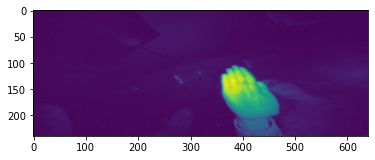

(240, 640)

In [4]:
# Посмотрим на один из жестов
im = plt.imread('C:/temp/leapGestRecog/0/frame_00_01_0001.png')
plt.imshow(im)
plt.show()
im.shape

In [20]:
# Трансформации
transforms = tt.Compose([# Настройки для расширения датасета
                         tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(45),               # Случайные повороты на 30 градусов
                         tt.Resize((64,64), interpolation=Image.NEAREST), #Image.NEAREST),
                         tt.ToTensor(),
                         tt.Normalize((0.1307,), (0.3081,)),
])                      # Приведение к тензору

In [21]:
print(transforms(Image.fromarray(im*255))[0])

tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.3478, -0.3733, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.3478, -0.3733, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.3478, -0.3478, -0.4242],
        ...,
        [-0.4242, -0.3606, -0.3224,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.3733, -0.3224,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.3606, -0.3351,  ..., -0.4242, -0.4242, -0.4242]])


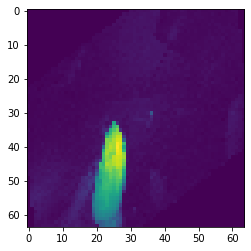

In [22]:
#plt.imshow(transforms(mask))
#plt.imshow(transforms(Image.fromarray(np.uint8(mask*255)))[0])
plt.imshow(transforms(Image.fromarray(im*255))[0])
plt.show()

In [23]:
# Классы
digit_to_classname = {0: 'palm', 
                      1: 'I', 
                      2: 'fist', 
                      3: 'fist_moved', 
                      4: 'thumb', 
                      5: 'index', 
                      6: 'ok',
                      7: 'palm_moved',
                      8: 'c',
                      9: 'down'}

In [24]:
# Число классов
class_count = len(digit_to_classname)

In [25]:
# Загрузка датасета
dataset = ImageFolder('C:/Temp/leapGestRecog', transforms)

In [26]:
dataset.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [27]:
dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: C:/Temp/leapGestRecog
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-45, 45), resample=False, expand=False)
               Resize(size=(64, 64), interpolation=PIL.Image.NEAREST)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

(tensor([[[-0.4242, -0.3351, -0.3224,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.3351, -0.3097,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.3224, -0.3224,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [-0.4242, -0.4242, -0.4242,  ..., -0.3478, -0.3733, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.3733, -0.3988, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.3733, -0.4242, -0.4242]]]), 0)
torch.Size([1, 64, 64])
0


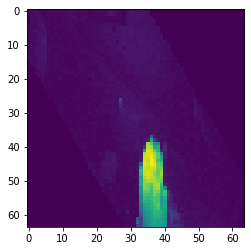

In [28]:
for i in dataset:
    print(i)
    print(i[0].shape)
    print(i[1])
    plt.imshow(i[0][0])
    plt.show()
    break

In [29]:
# Делим на трейн и тест
index_train, index_test = train_test_split(range(len(dataset)), test_size=0.3, random_state=42)

In [30]:
BATCH_SIZE = 50

In [31]:
sampler_train = SubsetRandomSampler(index_train)
sampler_test = SubsetRandomSampler(index_test)

loader_train = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_train, pin_memory=True)
loader_test = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler_test, pin_memory=True)

### Обучение

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [33]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(self.conv_block(64, 64), self.conv_block(64, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(64, 128)
        self.conv4 = self.conv_block(128, 128, pool=True)
        self.res2 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(128, 256)
        self.conv6 = self.conv_block(256, 256, pool=True)
        self.res3 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(256, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [34]:
model = ResNet(1, class_count).to(device)

In [35]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()

epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [36]:
total_steps = len(loader_train)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

10 epochs, 280 total_steps per epoch


In [37]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(loader_train))

1.6.0


In [38]:
%%time
epoch_losses = []

# Через каждые 140 итераций показываем промежуточный результат
N_OUT = 140 # total_steps / 2

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(loader_train):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
                
        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
        if (batch_idx + 1) % N_OUT == 0:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/N_OUT}')
            time2 = time.time()
            print(f'Spend time for {N_OUT} images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
            
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Train Epoch: 1, Loss: 2.287157108954021
Spend time for 140 images: 23.125430583953857 sec
Train Epoch: 1, Loss: 1.1109793239406176
Spend time for 140 images: 21.23418426513672 sec
Epoch 1, loss:  1.6990682164473192
Train Epoch: 2, Loss: 0.6560123277562006
Spend time for 140 images: 18.484541177749634 sec
Train Epoch: 2, Loss: 0.4434708891170365
Spend time for 140 images: 18.408745527267456 sec
Epoch 2, loss:  0.5497416084366186
Train Epoch: 3, Loss: 0.28614674088146
Spend time for 140 images: 18.302029371261597 sec
Train Epoch: 3, Loss: 0.21705059645963568
Spend time for 140 images: 18.42171025276184 sec
Epoch 3, loss:  0.25159866867054786
Train Epoch: 4, Loss: 0.1392369325272739
Spend time for 140 images: 18.50149655342102 sec
Train Epoch: 4, Loss: 0.11274356485477516
Spend time for 140 images: 18.757812023162842 sec
Epoch 4, loss:  0.12599024869102451
Train Epoch: 5, Loss: 0.08447758848113673
Spend time for 140 images: 18.60721254348755 sec
Train Epoch: 5, Loss: 0.07064976970432327
S

KeyboardInterrupt: 

Text(0.5, 1.0, 'losses vs. No. of epochs')

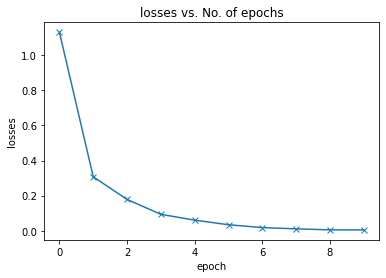

In [30]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [31]:
# Сохраним модель
torch.save(model.state_dict(), './models/model1.pth')

### Тестирование модели

In [32]:
net=ResNet(1, class_count).to(device)
net.load_state_dict(torch.load('./models/model1.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

C:\Users\rseme\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


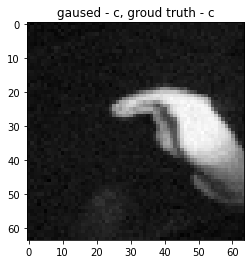

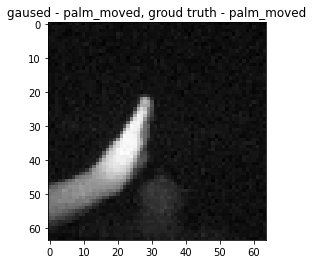

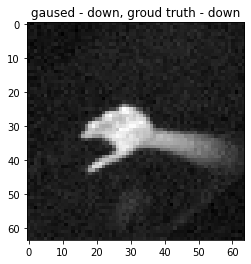

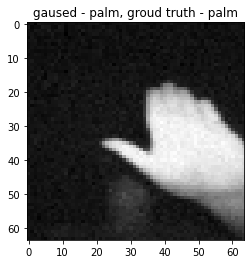

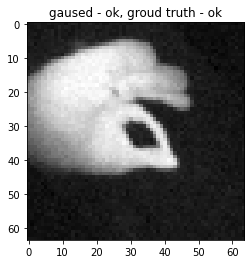

Доля правильно предсказанных жестов: 1.0


In [33]:
result = []

with torch.no_grad():
    for i, data in enumerate(loader_test):
        images, labels = data
        images, labels = Variable(images,volatile=True).cuda(), Variable(labels,volatile=True).cuda()
        outputs = net(images)
        result.append(int(outputs[0].argmax() == labels[0]))
        
        if i < 5:
            predict_class = digit_to_classname[int(outputs[0].argmax().detach().cpu().numpy())]
            truth_class = digit_to_classname[int(labels[0].detach().cpu().numpy())]
            plt.title(f'gaused - {predict_class}, groud truth - {truth_class}')
            plt.imshow(images[0].cpu().squeeze(), cmap='gray')
            plt.show()
            
print("Доля правильно предсказанных жестов:", sum(result) / len(result))